In [1]:
# %matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)


import torch
from torch import nn
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, AUROC
import time
import torch.nn.functional as F

from sklearn.model_selection import StratifiedShuffleSplit
SEED = 1234

In [2]:
dataDir='coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
# initialize COCO api for instance annotations
coco_train=COCO(annFile)

dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco_val = COCO(annFile)

loading annotations into memory...
Done (t=21.82s)
creating index...
index created!
loading annotations into memory...
Done (t=2.37s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco_train.loadCats(coco_train.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
electronic sports kitchen person vehicle food indoor appliance outdoor accessory furniture animal


In [103]:
# # get all images containing given categories, select one at random
# catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
# print(catIds)
# imgIds = coco.getImgIds(catIds=catIds );
# print(imgIds)
# imgIds = coco.getImgIds(imgIds = [324158])
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [104]:
# category_ids = coco.getCatIds(catNms=['person'])
# imgIds = coco.getImgIds(catIds=category_ids )
# print(imgIds)
# # img_id = imgIds[np.random.randint(0,len(imgIds))]
# img_id = imgIds[0]
# img = coco.loadImgs(img_id)[0]
# annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=category_ids, iscrowd=False)
# annotations = coco.loadAnns(annotation_ids)

In [105]:
# nms = set([cat['supercategory'] for cat in cats])
# id_dict = {}
# for nm in nms:
#     category_ids = coco.getCatIds(supNms=[nm])
#     img_ids = []
#     for cat_id in category_ids:
#         img_ids.extend(coco.getImgIds(catIds=cat_id))
#     print(len(img_ids))
#     id_dict[nm] = img_ids

In [106]:
# intersections = {}

# for key, value in id_dict.items():
#     intersections[key] = []
#     for key_2, value_2 in id_dict.items():
#         if key != key_2:
#             intersections[key].extend(x for x in list(set(value).intersection(value_2)) if x not in intersections[key])

In [107]:
# no_intersections = {}
# sum = 0
# for key, value in intersections.items():
#     no_intersections[key] = [x for x in id_dict[key] if x not in value]
#     print(key, len(id_dict[key]), len(value), len(no_intersections[key]))
#     sum += len(no_intersections[key])
# print(sum)

In [5]:
    # animal_category_ids = coco_train.getCatIds(supNms=['animal'])
animal_category_ids = [17,18] # cat=17, dog=18

In [6]:
animal_id_dict = {}

for cat_id in animal_category_ids:
    animal_id_dict[cat_id] = coco_train.getImgIds(catIds=cat_id)
    print(len(animal_id_dict[cat_id]))

animal_id_dict_val = {}
print('\n')
for cat_id in animal_category_ids:
    animal_id_dict_val[cat_id] = coco_val.getImgIds(catIds=cat_id)
    print(len(animal_id_dict_val[cat_id]))


4114
4385


184
177


In [7]:
animal_intersections = {}
for key, value in animal_id_dict.items():
    animal_intersections[key] = []
    for key_2, value_2 in animal_id_dict.items():
        if key != key_2:
            animal_intersections[key].extend(x for x in list(set(value).intersection(value_2)) if x not in animal_intersections[key])

animal_intersections_val = {}
for key, value in animal_id_dict_val.items():
    animal_intersections_val[key] = []
    for key_2, value_2 in animal_id_dict_val.items():
        if key != key_2:
            animal_intersections_val[key].extend(x for x in list(set(value).intersection(value_2)) if x not in animal_intersections_val[key])

In [8]:
animal_no_intersections = {}
sum = 0
for key, value in animal_intersections.items():
    animal_no_intersections[key] = [x for x in animal_id_dict[key] if x not in value]
    print(key, len(animal_id_dict[key]), len(value), len(animal_no_intersections[key]))
    sum += len(animal_no_intersections[key])
print(sum)


animal_no_intersections_val = {}
sum_val = 0
for key, value in animal_intersections_val.items():
    animal_no_intersections_val[key] = [x for x in animal_id_dict_val[key] if x not in value]
    print(key, len(animal_id_dict_val[key]), len(value), len(animal_no_intersections_val[key]))
    sum_val += len(animal_no_intersections_val[key])
print(sum_val)

17 4114 208 3906
18 4385 208 4177
8083
17 184 12 172
18 177 12 165
337


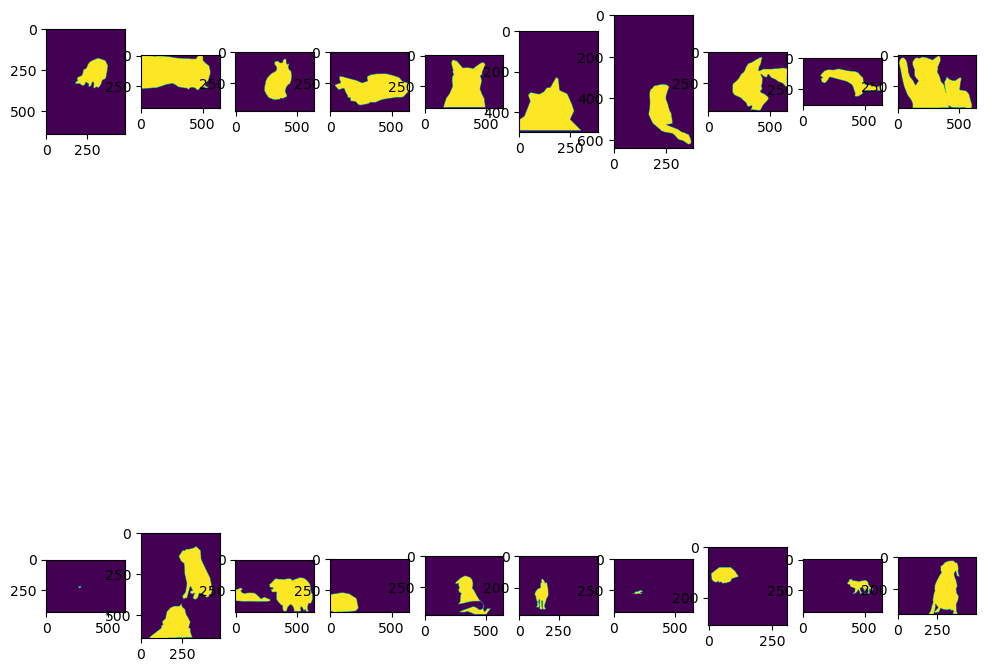

In [10]:
fig, axs = plt.subplots(2,10, figsize=(12,12))

i = 0
for animal, image_ids in animal_no_intersections.items():
    for j in range(10):
        # img = coco.loadImgs(image_ids[j])[0]
        annotation_ids = coco_train.getAnnIds(imgIds=image_ids[j], catIds=animal, iscrowd=False)
        annotations = coco_train.loadAnns(annotation_ids)
        # print(annotations)
        mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
        for annotation in annotations:
            # print(annotation)
            if annotation['category_id'] == animal:
                masks = coco_train.annToMask(annotation)
                # print(masks)
                mask += masks
        mask[mask!=0] = 1
        axs[i,j].imshow(mask)
    i += 1
plt.show()

{'license': 1, 'file_name': '000000286720.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000286720.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-15 05:35:24', 'flickr_url': 'http://farm4.staticflickr.com/3386/3346836280_ac5303bd50_z.jpg', 'id': 286720}
<PIL.Image.Image image mode=RGB size=224x224 at 0x29F97F49790>
{'license': 2, 'file_name': '000000073729.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000073729.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-18 00:35:46', 'flickr_url': 'http://farm1.staticflickr.com/130/321307778_7ac99d2f59_z.jpg', 'id': 73729}
<PIL.Image.Image image mode=RGB size=224x224 at 0x29F97F39090>
{'license': 6, 'file_name': '000000417802.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000417802.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-18 00:13:54', 'flickr_url': 'http://farm3.staticflickr.com/2150/2315944388_e2e1755ee3_z.jpg', 'id': 417802}
<PIL.Image.Image image mode=

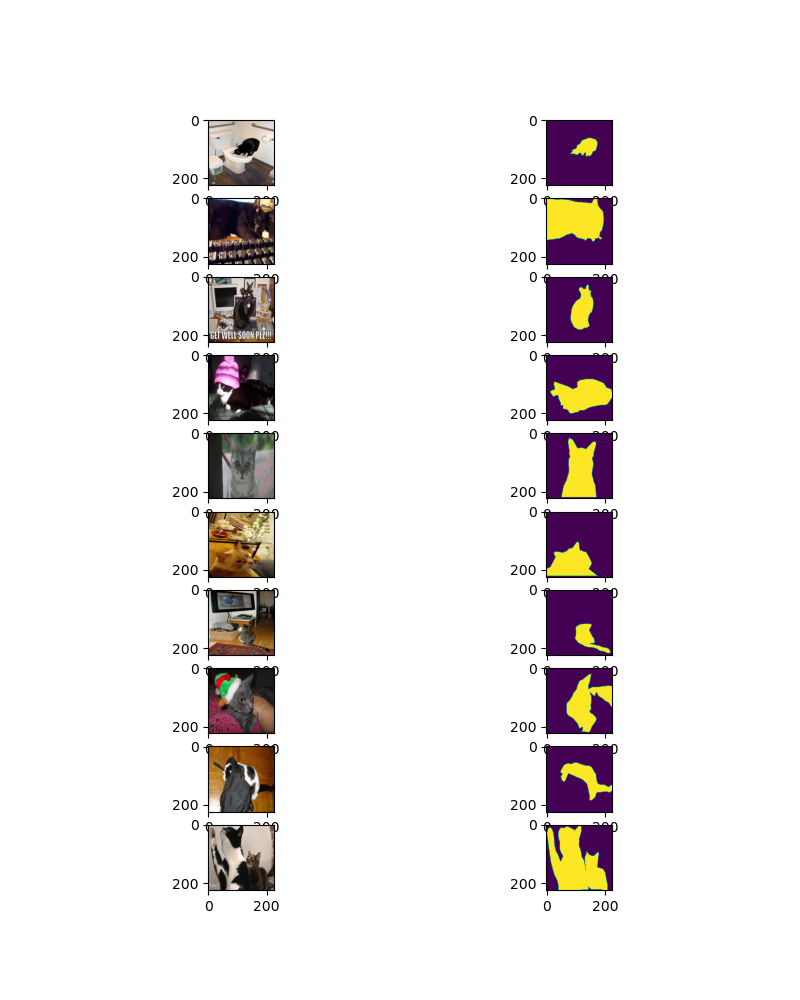

In [13]:
%matplotlib ipympl
from PIL import Image

fig, axs = plt.subplots(10,2)

animal = 17
image_ids = animal_no_intersections[animal]
# j = 1

for j in range(10):
    img = coco_train.loadImgs(image_ids[j])[0]
    print(img)
    
    with Image.open(f'./coco/train2017/{img["file_name"]}') as im:
        I = im.resize((224,224))
    print(I)
    # I = io.imread()
    # print(img['coco_url'])
    # print(I)
    
    annotation_ids = coco_train.getAnnIds(imgIds=image_ids[j], catIds=animal, iscrowd=False)
    annotations = coco_train.loadAnns(annotation_ids)
    
    mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
    for annotation in annotations:
        # print(annotation)
        if annotation['category_id'] == animal:
            masks = coco_train.annToMask(annotation)
            # print(masks)
            mask += masks
    mask[mask!=0] = 1
    
    mask_im = Image.fromarray(np.uint8(mask)).convert('RGB').resize((224,224))
    
    axs[j,0].imshow(I)
    axs[j,1].imshow(np.array(mask_im)[:,:,0])

plt.show()
# axs[1,0].imshow(I.resize((224,224)))

In [14]:
import cv2


In [15]:
mask = coco_train.annToMask(annotations[0])

In [16]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/histogram-equalization-with-python-and.html
    # https://en.wikipedia.org/wiki/Histogram_equalization
    # https://stackoverflow.com/a/28520445
    
    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

In [17]:
img

{'license': 3,
 'file_name': '000000458762.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000458762.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-17 16:01:51',
 'flickr_url': 'http://farm8.staticflickr.com/7180/7094140905_2d859f947b_z.jpg',
 'id': 458762}

[[150 153 156 ... 117 114 112]
 [151 158 161 ... 115 112 110]
 [153 159 165 ... 111 116 119]
 ...
 [116 114 114 ... 105 101  92]
 [117 113 115 ... 106 106 102]
 [119 112 117 ... 106 107 106]]
0.0
0.75
0.0
0.5
0.0
0.25


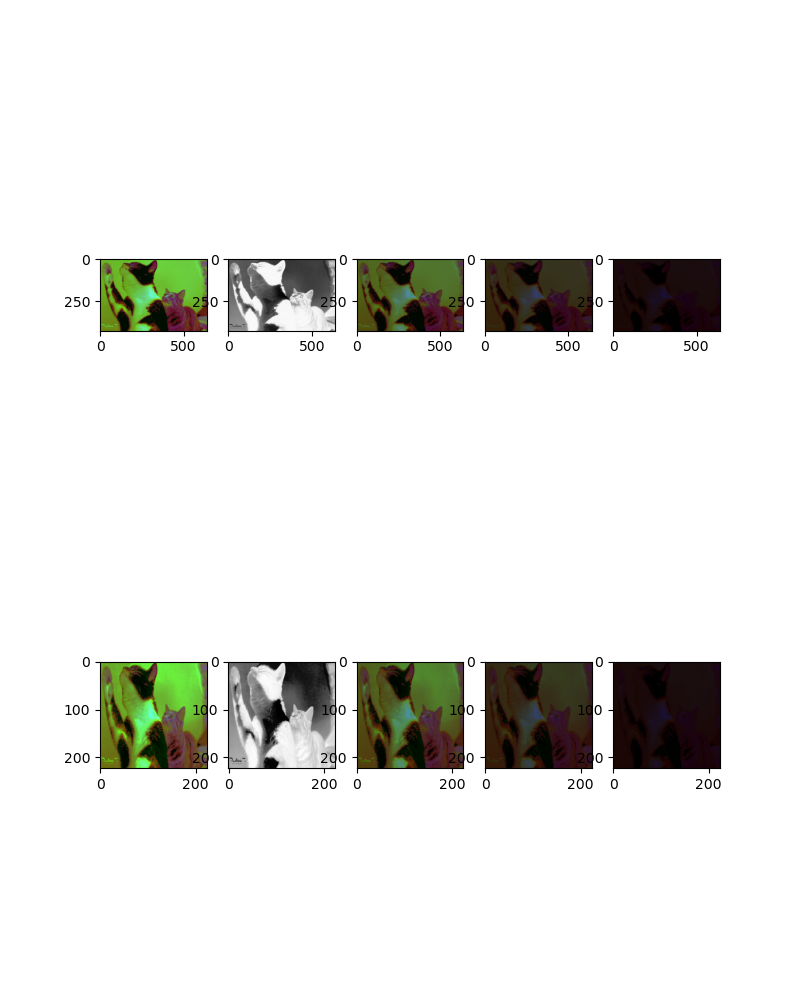

In [18]:
fig, axs = plt.subplots(2,5)
I = cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR)
out = cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ) / 255 # a bitmap conversion
axs[0,0].imshow(out)
axs[0,1].imshow(np.asarray(out)[:,:,1], cmap='Grays')

I = cv2.resize(cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR), (224,224))
out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ))  # a bitmap conversion 

out_norm[:,:,1] = image_histogram_equalization(out_norm[:,:,1])[0]
print(out_norm[:,:,1])
axs[1,0].imshow(out_norm)
axs[1,1].imshow(out_norm[:,:,1], cmap='Grays')

out_norm = out_norm / 255

for i, scalar in enumerate([0.75,0.5,0.25]):
    out_copy = np.asarray(out).copy()
    out_copy[:,:,1] = scalar * out_copy[:,:,1]

    out_norm_copy = out_norm.copy()
    out_norm_copy[:,:,1] = scalar * out_norm_copy[:,:,1]

    print(out_norm_copy[:,:,1].min())
    print(out_norm_copy[:,:,1].max())
    
    axs[0,i+2].imshow(scalar*out_copy, cmap='Grays', vmin=0, vmax=255)

    # out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS )) # a bitmap conversion
    # out_norm[:,:,1] = image_histogram_equalization(out_norm[:,:,1])[0]
    
    axs[1,i+2].imshow(scalar*out_norm_copy, cmap='Grays', vmin=0, vmax=255)

In [118]:
# for key, value in animal_no_intersections_val.items():
#     animal_no_intersections[key].extend(value)

In [22]:
n = 7000
n_per_class = 3500
data = np.zeros((n, 224,224,3))
labels = np.zeros((n,))
masks = np.zeros((n, 224,224))

j = 0
for i, (key, value) in enumerate(animal_no_intersections.items()):
    if len(value) >= n_per_class:
        print(i, key, len(value))

        for id in value[:n_per_class]:
            img = coco_train.loadImgs(id)[0]
    
            I = cv2.resize(cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR), (224,224))

            out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ))  # a bitmap conversion 
            out_norm[:,:,1] = image_histogram_equalization(out_norm[:,:,1])[0]
            out_norm = out_norm / 255
            
            annotation_ids = coco_train.getAnnIds(imgIds=id, catIds=key, iscrowd=False)
            annotations = coco_train.loadAnns(annotation_ids)
            
            mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
            for annotation in annotations:
                # print(annotation)
                if annotation['category_id'] == key:
                    masks_animal = coco_train.annToMask(annotation)
                    # print(masks)
                    mask += masks_animal
            mask[mask!=0] = 1

            mask_im = Image.fromarray(np.uint8(mask)).convert('RGB').resize((224,224))
            
            data[j] = out_norm
            labels[j] = i
            masks[j] = np.asarray(mask_im)[:,:,0]
            
            j+=1

0 17 3906
1 18 4177


In [149]:
# import pickle as pkl

# # with open('coco_data.pkl', 'wb') as f:
# #     pkl.dump(data, f)


# nine_inds = np.where(labels==9)[0]
# labels[nine_inds] = 4

# with open('coco_labels.pkl', 'wb') as f:
#     pkl.dump(labels, f)
    
# with open('coco_masks.pkl', 'wb') as f:
#     pkl.dump(masks, f)

In [24]:
# Shuffled 60/20/20 split
# split 60/40 into train and val+test, then split val and test by half

data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=SEED)
train_indices, val_indices = list(data_splitter.split(X=data, y=labels))[0]


x_train = data[train_indices]
y_train = labels[train_indices]
x_val_test = data[val_indices]
y_val_test = labels[val_indices]

data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = list(data_splitter.split(X=x_val_test, y=y_val_test))[0]

x_val = x_val_test[val_indices]
y_val = y_val_test[val_indices]

x_test = x_val_test[test_indices]
y_test = y_val_test[test_indices]

In [26]:
import pickle as pkl
split_dataset = [(x_train, y_train, masks[train_indices]), (x_val, y_val, masks[val_indices]), (x_test, y_test, masks[test_indices])]

with open('coco_data_cats_and_dogs.pkl', 'wb') as f:
    pkl.dump(split_dataset, f)

In [17]:
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (112360x160 and 800x128)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
        
        self.maxPooling2=nn.MaxPool2d(kernel_size=2)
        self.maxPooling4_0=nn.MaxPool2d(kernel_size=4)
        self.maxPooling4_1=nn.MaxPool2d(kernel_size=4)
#         self.adPooling=nn.AdaptiveAvgPool1d(256)
        
        self.fc1=nn.Linear(in_features=4096,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.out=nn.Linear(in_features=64,out_features=5)

    def forward(self,x):
        x=self.conv1(x)
        x=self.maxPooling4_0(x)
        x=F.relu(x)
        
        x=self.conv2(x)
        x=self.maxPooling4_1(x)
        x=F.relu(x)
        
        x=self.conv3(x)
        x=self.maxPooling2(x)
        x=F.relu(x)
        
        x=F.dropout(x)
        x=x.view(1,x.size()[0],-1) #stretch to 1d data
        #x=self.adPooling(x).squeeze()
        
        x=self.fc1(x)
        x=F.relu(x)
        
        x=self.fc2(x)
        x=F.relu(x)
        
        x=self.out(x)
        
        return x[0]

In [4]:
def train(lr,epochs,train_loader,val_loader,name_model,momentum=0.9,weight_decay=1e-3,num_models=10):
    DEVICE='cpu'
    
    metric = AUROC(task='multiclass', num_classes=5) 
    softmax = nn.Softmax(dim=1)
    
    training_accuracy = Accuracy(task='multiclass', num_classes=5).to(DEVICE)
    val_accuracy = Accuracy(task='multiclass', num_classes=5).to(DEVICE)

    torch.manual_seed(SEED)

    trained_models = []
    training_logs = []

    for training_ind in range(num_models):
        cnn_conf=Net()
        cnn_conf.to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        
        # Anders et. al uses mainly AdaDelta but also SGD in one section
#         optimizer = optim.SGD(cnn_conf.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        optimizer = optim.Adadelta(cnn_conf.parameters(), lr=lr, weight_decay=weight_decay)


        loss_list_train=[]
        loss_list_val=[]
        acc_list_train=[]
        acc_list_val=[]
        

        min_loss = 100000000
    #     last_loss = 1000000000

        for epoch in range(epochs):  # loop over the dataset multiple times
            print(f' epoch {epoch+1} in {epochs}')
            t0=time.time()
            epoch_loss = 0.0
            epoch_loss_val= 0.0
            batch_acc=[]
            batch_acc_val=[]

            auroc_train=[]
            auroc_val=[]

            pred_train=[]
            pred_val=[]
            true_labels_train=[]
            true_labels_val=[]

            for i, batch in enumerate(train_loader):
                inputs, labels = batch

                inputs = inputs.to(DEVICE,dtype=torch.float)
                labels = labels.type(torch.LongTensor)
                labels=labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = cnn_conf(inputs).squeeze()
                _, predicted = torch.max(outputs.data,1)

                # print(outputs.shape)
                # print(labels.shape)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()        
                batch_acc.append(training_accuracy(predicted, labels).item())

#                 print(softmax(outputs)[:,1].detach().numpy().shape)
#                 pred_train=np.concatenate((pred_train, softmax(outputs)[:,1].detach().numpy()))
#                 true_labels_train=np.concatenate((true_labels_train, labels.cpu().numpy()))
                
                auroc_train.append(metric(outputs,labels.to(torch.int32)))

            auroc_train = sum(auroc_train)/len(auroc_train)

            for i_v, data_val in enumerate(val_loader):
                inputs_val, labels_val = data_val

                inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
                labels_val = labels_val.type(torch.LongTensor)
                labels_val=labels_val.to(DEVICE)

                outputs_val = cnn_conf(inputs_val).squeeze()
                _, predicted_val = torch.max(outputs_val.data, 1)

                loss_val = criterion(outputs_val, labels_val)

                epoch_loss_val += loss_val.item()        
                batch_acc_val.append(val_accuracy(predicted_val, labels_val).item())

                auroc_val.append(metric(outputs_val,labels_val.to(torch.int32)))

#                 pred_val=np.concatenate((pred_val, softmax(outputs_val)[:,1].cpu().detach().numpy()))
#                 true_labels_val=np.concatenate((true_labels_val, labels_val.cpu().detach().numpy()))
            auroc_val = sum(auroc_val)/len(auroc_val)

            if epoch_loss_val < min_loss:
                min_loss = epoch_loss_val
                save_model = type(cnn_conf)() # get a new instance
                save_model.load_state_dict(cnn_conf.state_dict()) # copy weights and stuff

                torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

#             auroc_val=metric(torch.tensor(pred_val),torch.tensor(true_labels_val).to(torch.int32))

            epoch_acc=sum(batch_acc)/len(batch_acc)
            epoch_acc_val=sum(batch_acc_val)/len(batch_acc_val)

            print(f'epoch train loss: {epoch_loss} | epoch train acc {epoch_acc} | AUROC: {auroc_train}')
            print(f'epoch val loss: {epoch_loss_val} | epoch val acc {epoch_acc_val} | AUROC: {auroc_val}')
            print(f'time elapsed: {round(time.time()-t0,2)} s')

            loss_list_train.append(epoch_loss)
            loss_list_val.append(epoch_loss_val)
            acc_list_train.append(epoch_acc)
            acc_list_val.append(epoch_acc_val)

            epoch_loss = 0.0
            epoch_loss_val=0.0

        print('Finished Training')
        print()
        print('\t \t *******************')
        print()
        
        torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

        trained_models.append(save_model)
        training_logs.append([acc_list_train, loss_list_train, acc_list_val, loss_list_val])
#     plt.plot(loss_list_train)
#     plt.plot(loss_list_val)
#     plt.plot([i*100 for i in acc_list_train])
#     plt.plot([i*100 for i in acc_list_va])
    return trained_models, [acc_list_train, loss_list_train, acc_list_val, loss_list_val]

In [2]:
# split_dataset = [(x_train, y_train, masks[train_indices]), (x_val, y_val, masks[val_indices]), (x_test, y_test, masks[test_indices])]
import pickle as pkl
with open('coco_data.pkl', 'rb') as f:
    [(x_train, y_train, _), (x_val, y_val, _), (x_test, y_test, _)] = pkl.load(f)

In [13]:
train_inds = np.where(y_train==9)[0]
val_inds = np.where(y_val==9)[0]
test_inds = np.where(y_test==9)[0]

y_train[train_inds] = 4
y_val[val_inds] = 4
y_test[test_inds] = 4

In [1]:
batch_size = 32

train_loader = DataLoader(TensorDataset(torch.tensor(x_train.transpose(0,3,1,2)), torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(x_val.transpose(0,3,1,2)), torch.tensor(y_val)), batch_size=batch_size, shuffle=True)

NameError: name 'DataLoader' is not defined

In [2]:
lr = 0.005
epochs = 50
num_models=1

train(lr,epochs,train_loader,val_loader,'coco_control',momentum=0.9,weight_decay=1e-3,num_models=num_models)

NameError: name 'train' is not defined